In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import kendalltau

In [2]:
data_root = '../../../data/Streamflow/fpe_stations'
stations = sorted([f.name for f in Path(data_root).iterdir() if f.is_dir() and f.name not in ['FOXRC', 'GREENR', 'LANESV', 'VLYB', 'WESTKILL']])
print(stations)
stations_done = stations[0:]
print(stations_done)

['Avery Brook_Bridge_01171000', 'Avery Brook_River Left_01171000', 'Avery Brook_River Right_01171000', 'Avery Brook_Side_01171000', 'Sanderson Brook_01171010', 'West Branch Swift River_01174565', 'West Brook 0_01171100', 'West Brook Lower_01171090', 'West Brook Reservoir_01171020', 'West Brook Upper_01171030', 'West Whately_01171005']
['Avery Brook_Bridge_01171000', 'Avery Brook_River Left_01171000', 'Avery Brook_River Right_01171000', 'Avery Brook_Side_01171000', 'Sanderson Brook_01171010', 'West Branch Swift River_01174565', 'West Brook 0_01171100', 'West Brook Lower_01171090', 'West Brook Reservoir_01171020', 'West Brook Upper_01171030', 'West Whately_01171005']


In [18]:
DATA_DIR = data_root
def load_site_annotations(site, data_dir=DATA_DIR):
    # read timezone from stations.json file
    site_json = json.load(open(Path(data_dir, site, 'FLOW_CFS', 'station.json'), 'r'))
    site_timezone = site_json['timezone']

    annotations = pd.read_csv(Path(data_dir, site, 'FLOW_CFS', 'annotations.csv'))
    annotations['left.timestamp'] = pd.to_datetime(annotations['left.timestamp']).dt.tz_convert(site_timezone)
    annotations['right.timestamp'] = pd.to_datetime(annotations['right.timestamp']).dt.tz_convert(site_timezone)
    return annotations

In [50]:
results_root = '../results/vary_annot_frac.kernighan-lin_test'
all_NAN_values = ['West Brook Upper_01171030']
ktau = dict()
ktau_test_dates = dict()

for station in stations_done:
    if station in all_NAN_values:
        continue
    ktau[station] = []
    ktau_test_dates[station] = []
    station_results_dirs = [f for f in Path(results_root).iterdir() if f.name.startswith(station)]
    for station_results_dir in station_results_dirs:
        print(station_results_dir)
        train_filename = station_results_dir.name.replace(station, '')[1:] + '.csv'
        train_file = Path('../data/processed') / station / 'FLOW_CFS' / 'kernighan-lin_test.vary_n_train_annot' / train_filename
        train_data = pd.read_csv(train_file)
        n_pairs = train_data.shape[0]
        test_file = str(train_file).split('-train')[0] + '-test.csv'
        test_annots = pd.read_csv(test_file)
        site_json = json.load(open(Path(DATA_DIR, station, 'FLOW_CFS', 'station.json'), 'r'))
        site_timezone = site_json['timezone']
        test_annots['left.timestamp'] = pd.to_datetime(test_annots['left.timestamp'],utc=True).dt.tz_convert(site_timezone)
        test_annots['right.timestamp'] = pd.to_datetime(test_annots['right.timestamp'],utc=True).dt.tz_convert(site_timezone)
        left_dates = test_annots['left.timestamp'].dt.date
        right_dates = test_annots['right.timestamp'].dt.date
        test_dates = list(set(left_dates) | set(right_dates))
        results = pd.read_csv(station_results_dir / 'inference' / 'inference_ranking_model_1' / 'inference_results_images.csv')
        results_with_flow = results.dropna(subset=['value']).copy()
        results_with_flow['timestamp'] = pd.to_datetime(results_with_flow['timestamp'],utc=True).dt.tz_convert(site_timezone)
        results_with_flow_test_dates = results_with_flow.loc[results_with_flow['timestamp'].dt.date.isin(test_dates)]
        tau = kendalltau(results_with_flow['value'], results_with_flow['scores']).correlation
        tau_test_dates = kendalltau(results_with_flow_test_dates['value'], results_with_flow_test_dates['scores']).correlation
        ktau[station].append((n_pairs, tau))
        ktau_test_dates[station].append((n_pairs, tau_test_dates))
    ktau[station].sort(key=lambda x: x[0])
    ktau_test_dates[station].sort(key=lambda x: x[0])

../results/vary_annot_frac.kernighan-lin_test/Avery Brook_Bridge_01171000-pairs-train-1000
../results/vary_annot_frac.kernighan-lin_test/Avery Brook_Bridge_01171000-pairs-train-2000
../results/vary_annot_frac.kernighan-lin_test/Avery Brook_Bridge_01171000-pairs-train
../results/vary_annot_frac.kernighan-lin_test/Avery Brook_Bridge_01171000-pairs-train-1500
../results/vary_annot_frac.kernighan-lin_test/Avery Brook_Bridge_01171000-pairs-train-2500
../results/vary_annot_frac.kernighan-lin_test/Avery Brook_Bridge_01171000-pairs-train-500
../results/vary_annot_frac.kernighan-lin_test/Avery Brook_River Left_01171000-pairs-train-500
../results/vary_annot_frac.kernighan-lin_test/Avery Brook_River Left_01171000-pairs-train-1000
../results/vary_annot_frac.kernighan-lin_test/Avery Brook_River Left_01171000-pairs-train-1500
../results/vary_annot_frac.kernighan-lin_test/Avery Brook_River Left_01171000-pairs-train
../results/vary_annot_frac.kernighan-lin_test/Avery Brook_River Right_01171000-pairs-t

In [51]:
ktau

{'Avery Brook_Bridge_01171000': [(500, 0.4611755676383798),
  (1000, 0.5337531980827),
  (1500, 0.5412388232051134),
  (2000, 0.5162021301599267),
  (2500, 0.516097919431776),
  (2602, 0.5524729148930533)],
 'Avery Brook_River Left_01171000': [(500, 0.5508936039527462),
  (1000, 0.6261769349419867),
  (1500, 0.6113741087464424),
  (1984, 0.6200198554508779)],
 'Avery Brook_River Right_01171000': [(500, 0.5144285642832556),
  (1000, 0.615590939861809),
  (1500, 0.6078963133752874),
  (1985, 0.6339366261401627)],
 'Avery Brook_Side_01171000': [(500, 0.677538059465488),
  (1000, 0.7024180324282937),
  (1500, 0.7352901424316104),
  (2000, 0.7208704740080398),
  (2000, 0.7323876570765501)],
 'Sanderson Brook_01171010': [(500, 0.4478481629000266),
  (1000, 0.5395034196180776),
  (1500, 0.6351661269415316),
  (2000, 0.6325147408137343),
  (2500, 0.6377153948902413),
  (3000, 0.6518815547394863),
  (3500, 0.6531765254738144),
  (3897, 0.658030882856994)],
 'West Branch Swift River_01174565': [

In [52]:
ktau_test_dates

{'Avery Brook_Bridge_01171000': [(500, 0.38426061081684154),
  (1000, 0.48860418848435816),
  (1500, 0.4798259598154465),
  (2000, 0.4440063109332282),
  (2500, 0.46043937103025273),
  (2602, 0.4990915060785422)],
 'Avery Brook_River Left_01171000': [(500, 0.4758114336463558),
  (1000, 0.5756175428402887),
  (1500, 0.5588276086320998),
  (1984, 0.5732595508820175)],
 'Avery Brook_River Right_01171000': [(500, 0.5604366416722084),
  (1000, 0.6218061239200972),
  (1500, 0.6099800223938697),
  (1985, 0.6708180465800182)],
 'Avery Brook_Side_01171000': [(500, 0.6982790982552546),
  (1000, 0.7078500792691116),
  (1500, 0.7222070491523148),
  (2000, 0.7236736012587205),
  (2000, 0.7388125835298448)],
 'Sanderson Brook_01171010': [(500, 0.4435900933550442),
  (1000, 0.5496192937980102),
  (1500, 0.6401365910828861),
  (2000, 0.643921851701468),
  (2500, 0.6447511343278545),
  (3000, 0.6573481216094786),
  (3500, 0.6573365207252194),
  (3897, 0.6611878794052782)],
 'West Branch Swift River_011

/tmp/ipykernel_667415/1563812776.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(ktau))


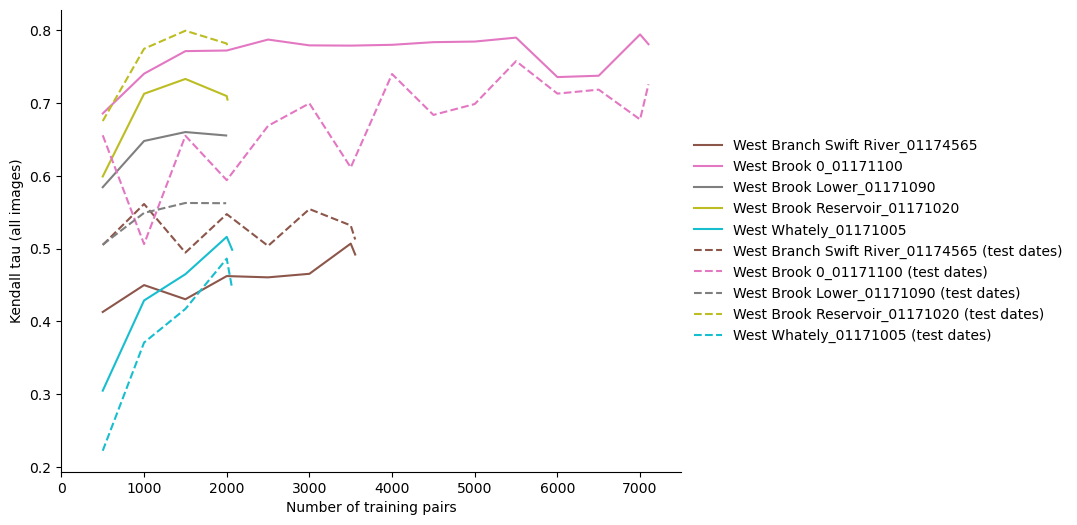

In [57]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# Create a color map
colors = plt.cm.get_cmap('tab10', len(ktau))

for i, station in enumerate(ktau):
    if i > 4:
        n_pairs, tau = zip(*ktau[station])
        ax.plot(n_pairs, tau, label=station, color=colors(i))

for i, station in enumerate(ktau_test_dates):
    if i > 4:
        n_pairs, tau = zip(*ktau_test_dates[station])
        ax.plot(n_pairs, tau, label=station + ' (test dates)', linestyle='--', color=colors(i))

ax.set_xlabel('Number of training pairs')
ax.set_ylabel('Kendall tau (all images)')
ax.set_xlim(0, 7500)
# ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

In [7]:
# Count the total length of results across all stations
total_length = 0
for station in ktau:
    n_pairs, tau = zip(*ktau[station])
    total_length += len(n_pairs)
print(total_length)

53


In [60]:
# count the number of test dates in each month
months = [d.month for d in test_dates]
month_counts = {m: months.count(m) for m in set(months)}
month_counts

{1: 2, 2: 4, 3: 5, 4: 5, 5: 7, 6: 3, 7: 5, 8: 7, 9: 3, 10: 3, 11: 7, 12: 7}